## SLI Training Script 
## By Luis A. Urso
## 13-MAR-2023 - version 2
##
## Release Notes:
## - Hyperparameters adjustments: Changed the RNN architecture, 1st Drop-Out to 10% and 2nd Drop-Out to 5%
## - Full code review

In [1]:
import csv
import os
import sys

import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from keras.utils import plot_model

import seaborn as sns
import matplotlib.pyplot as plt


RANDOM_SEED = 42

# Setup Global Variables

 Define the files path

In [2]:
dataset = 'model/training_data.csv'
model_save_path = 'model/training_classifierf.hdf5'
tflite_save_path = 'model/training_classifier.tflite'

def get_script_path():
    return os.path.dirname(os.path.realpath(sys.argv[0]))


app_path=get_script_path()

Set number of classes to be trained

In [25]:
# Define the number of classes to be trained 

with open('model/labels.csv',encoding='utf-8-sig') as f_labels:
	labels_class = csv.reader(f_labels)
	labels_class = [
		row[0] for row in labels_class
	]

# Get the Classes Text

classes_text=[]
for rlb in labels_class:
	if rlb!="None":
		classes_text.append(rlb)


NUM_CLASSES = len(labels_class)

print("Classes to be trained:",NUM_CLASSES)

Classes to be trained: 27


# Dataset Preparation

Dataset loading

In [8]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [9]:
X_dataset.shape

(11622, 42)

In [10]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [11]:
y_dataset.shape

(11622,)

Split Data Sets into Train and Test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model Architecture & Building

FNN Model Arquitecture

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [15]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 27)                297       
                                                                 
Total params: 1,367
Trainable params: 1,367
Non-trainable params: 0
_________________________________________________________________


Model Pre-building Verification 

In [16]:
# Model checkpoint callback / Model Saving
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)

# Callback for early stopping / definitions
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

Model Compilation

In [17]:
# Model compilation

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model Training

In [18]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
42/69 [=================>............] - ETA: 0s - loss: 3.2706 - accuracy: 0.0255 
Epoch 1: saving model to model\training_classifierf.hdf5
69/69 [==============================] - 1s 4ms/step - loss: 3.2402 - accuracy: 0.0429 - val_loss: 3.1487 - val_accuracy: 0.1290
Epoch 2/1000
41/69 [================>.............] - ETA: 0s - loss: 3.0600 - accuracy: 0.1700
Epoch 2: saving model to model\training_classifierf.hdf5
69/69 [==============================] - 0s 2ms/step - loss: 2.9915 - accuracy: 0.1863 - val_loss: 2.7838 - val_accuracy: 0.2337
Epoch 3/1000
39/69 [===============>..............] - ETA: 0s - loss: 2.6832 - accuracy: 0.2462
Epoch 3: saving model to model\training_classifierf.hdf5
69/69 [==============================] - 0s 2ms/step - loss: 2.6008 - accuracy: 0.2711 - val_loss: 2.3526 - val_accuracy: 0.3723
Epoch 4/1000
37/69 [===============>..............] - ETA: 0s - loss: 2.2881 - accuracy: 0.3406
Epoch 4: saving model to model\training_classifierf.hdf5


# Training Evaluation

In [19]:
# Model evaluation

val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

23/23 [==============================] - 0s 753us/step - loss: 0.1606 - accuracy: 0.9618


In [20]:
# Loading the saved model

model = tf.keras.models.load_model(model_save_path)

In [21]:
# Inference Inference

predict_result = model.predict(np.array([X_test[1]]))
print("Test Label:",np.array([y_test[1]]))
print("Squeeze:", np.squeeze(predict_result)) # make it a single dimention
print("Predicted: ",np.argmax(np.squeeze(predict_result))) # get the index of the max element of the array

1/1 [==============================] - 0s 51ms/step
Test Label: [16]
Squeeze: [1.4149332e-22 1.4515973e-09 8.3634509e-14 6.4824668e-10 6.6910144e-07
 5.1888535e-15 7.9998143e-18 4.6921365e-09 1.8395008e-09 7.7602313e-13
 4.2939815e-11 4.7486195e-05 7.9515008e-03 8.8541166e-09 4.5031522e-04
 7.8249911e-07 4.4810227e-01 1.8235479e-08 1.2480620e-11 6.1057637e-10
 3.3995806e-05 1.9562821e-10 1.1673787e-10 2.3240507e-14 5.4341161e-01
 8.8526842e-12 1.3842887e-06]
Predicted:  24


# Confusion Matrix

91/91 [==============================] - 0s 660us/step


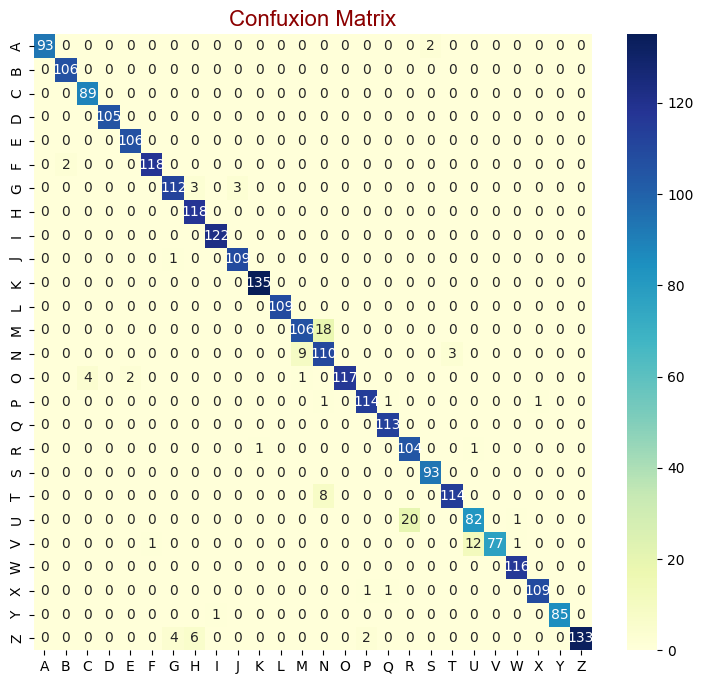

Classification Report
              precision    recall  f1-score   support

           1       1.00      0.98      0.99        95
           2       0.98      1.00      0.99       106
           3       0.96      1.00      0.98        89
           4       1.00      1.00      1.00       105
           5       0.98      1.00      0.99       106
           6       0.99      0.98      0.99       120
           7       0.96      0.95      0.95       118
           8       0.93      1.00      0.96       118
           9       0.99      1.00      1.00       122
          10       0.97      0.99      0.98       110
          11       0.99      1.00      1.00       135
          12       1.00      1.00      1.00       109
          13       0.91      0.85      0.88       124
          14       0.80      0.90      0.85       122
          15       1.00      0.94      0.97       124
          16       0.97      0.97      0.97       117
          17       0.98      1.00      0.99       113
     

In [34]:
# Set the font for confusion matrix

font = {'family': 'arial',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

def show_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=classes_text, columns=classes_text)
 
    fig, ax = plt.subplots(figsize=(9, 8))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False, cmap="YlGnBu")
    ax.set_ylim(len(set(y_true)), 0)
    plt.title("Confuxion Matrix",fontdict=font)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

show_confusion_matrix(y_test, y_pred)

# Convert Model for Tensorflow-Lite

In [59]:
# Save as a model dedicated to inference

model.save(model_save_path, include_optimizer=False)

In [60]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\laurs\AppData\Local\Temp\tmpbfhn5pqz\assets


INFO:tensorflow:Assets written to: C:\Users\laurs\AppData\Local\Temp\tmpbfhn5pqz\assets


7584

# Inference Test

In [61]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [62]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [63]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [64]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


Check if all labels were considered in the TFLITE converted RNN 

In [65]:
print(np.squeeze(tflite_results))
print("Recorded Labels:",np.argmax(np.squeeze(tflite_results))+1,"of",NUM_CLASSES,"Original Trained Labels:")
print("")
print("*** END OF TRAINIG ***")

[3.0074434e-19 2.1293570e-06 1.2437340e-18 1.0827206e-10 5.0428195e-10
 2.1687207e-17 1.4526939e-15 7.2825768e-10 1.3625900e-07 1.5117657e-10
 1.7076690e-10 2.4922614e-10 8.4324629e-04 2.8670357e-08 6.1591874e-07
 2.8558242e-09 9.9683785e-01 1.2873475e-03 1.0119452e-22 3.2681299e-12
 4.0450926e-10 9.3433640e-18 7.0136941e-13 1.3966983e-19 9.2897151e-04
 7.1968195e-08 9.9698496e-05]
Recorded Labels: 17 of 27 Original Trained Labels:

*** END OF TRAINIG ***
